<a href="https://colab.research.google.com/github/kshptl/AI-for-Trading/blob/main/Stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [87]:
import pandas as pd
import numpy as np
import datetime as dt
import os
from keras_OneCycle import OneCycle
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import keras
#import tensorflow as tf
#from tensorflow import keras

#import tensorflow.keras.models as M
#import tensorflow.keras.layers as L
#from keras import backend as K
#keras.backend

#import tensorflow as tf
#from tensorflow import keras #<------- use this for tensorflow



import matplotlib.pyplot as plt
#!pip install mplfinance
import mplfinance as mpf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns
from keras.utils.np_utils import to_categorical

In [2]:
cd data

/Users/kush/Desktop/DS/inpredo-master/RNN_tabular/AI-for-Trading/data


In [3]:
data = pd.read_csv("ND100.M5.csv", parse_dates=True,  names=["open", "high", "low", "close", "volume"])

# # change timeframe
logic = {'open'  : 'first',
         'high'  : 'max',
         'low'   : 'min',
         'close' : 'last',
         'volume': 'sum'}
offset = pd.offsets.timedelta(days=-6)
data = data.resample('1H', loffset=offset).apply(logic)

data.reset_index(drop=True, inplace=True)
data = data[["close", "open", "high", "low"]]
data['pandas_SMA_3'] = data.iloc[:,0].rolling(window=3).mean()
data = data.fillna(0)

In [4]:
data

,close,open,high,low,pandas_SMA_3
0,7224.7,7220.4,7226.6,7216.0,0.000000
1,7220.0,7224.6,7236.5,7207.2,0.000000
2,7218.4,7219.7,7253.9,7209.6,7221.033333
3,7186.5,7218.7,7235.2,7175.5,7208.300000
4,7196.5,7186.7,7211.0,7180.0,7200.466667
...,...,...,...,...,...
12577,11211.5,11145.1,11212.7,11114.4,11165.266667
12578,11345.5,11211.4,11347.5,11208.9,11234.066667
12579,11307.4,11345.0,11359.1,11298.6,11288.133333
12580,11308.5,11307.5,11338.9,11286.5,11320.466667


In [5]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1, predict_forward=3, column=3):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-predict_forward):
        j = i + look_back
        a = dataset[i:j,:]
        dataX.append(a)
		
        # for predicting actual price
        #dataY.append(dataset[j:j + predict_forward, column])

        # for % change
        #pct = (-data[i + look_back,3] + data[i + look_back+ predict_forward, 3])/data[i + look_back,3]
        #if data[i + look_back,3] == 0:
        #	print(i,"zero")

        # for direction
        if dataset[j,0] >= dataset[j-1,0]:
            dataY.append(1)
        else:
            dataY.append(0)

    return np.array(dataX), np.array(dataY)

In [134]:
# fix random seed for reproducibility
np.random.seed(42)
normalize_max = 1
# normalize the dataset
x_scaler = MinMaxScaler(feature_range=(0,normalize_max))
data = x_scaler.fit_transform(data)

# remove values that are 0
data = np.delete(data,np.where(data==0)[0],axis=0)

In [135]:
n_bars = 100
predict_forward = 1
x_train, y_train = create_dataset(data,n_bars, predict_forward=predict_forward, column=0)
#x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2],1) #add the channel at the end

#remove the last sample one bc it may not have enough  y_train values (if the dataset size doenst evenly divide into the sample size)
x_train = x_train[:-predict_forward]
y_train = np.stack(y_train[:-predict_forward])

In [136]:
# scale y_train
y_scaler = MinMaxScaler(feature_range=(0,1))
y_train = y_scaler.fit_transform(y_train.reshape(-1,1))
y_train = to_categorical(y_train)

In [142]:
np.unique(y_train, return_counts=True)

(array([0., 1.], dtype=float32), array([7606, 7606]))

In [140]:
# define model
regularizer = keras.regularizers.l2()
def make_model(input_shape):

#     model = keras.models.Sequential()
#     model.add(keras.layers.Conv1D(32, input_shape=input_shape, kernel_size=5, padding="same", activation="relu"))
#     model.add(keras.layers.MaxPool1D(3))
#     model.add(keras.layers.Flatten())
#     model.add(keras.layers.Dense(2, activation="sigmoid"))

    model = keras.models.Sequential()
    model.add(keras.layers.Dense(400, activation="relu"))
    model.add(keras.layers.Dense(800, activation="relu"))
    model.add(keras.layers.Dense(1200, activation="relu"))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(2, activation="sigmoid"))
    
    return model

model = make_model(input_shape=x_train.shape[1:])
model.build(input_shape=x_train.shape[:])

callbacks = [
    #OneCycle(min_lr=7e-6, max_lr=7e-2, min_mtm = 0.85, max_mtm = 0.95, annealing_stage=0.1, annealing_rate=0.01, training_iterations=np.ceil(((x_train.shape[0]*epochs)/(batch_size)))),

    keras.callbacks.ReduceLROnPlateau(monitor="val_acc", factor=0.5, patience=5, min_lr=0.0001),
    keras.callbacks.EarlyStopping(monitor="val_acc", patience=20, verbose=1),
]

opt = keras.optimizers.SGD(lr=1e-6)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

keras.utils.plot_model(model, show_shapes=True)
model.summary()

# Calling `save('my_model')` creates a SavedModel folder `my_model`.
#model.save("my_model")

# It can be used to reconstruct the model identically.
#reconstructed_model = keras.models.load_model("my_model")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (7606, 100, 400)          2400      
_________________________________________________________________
dense_48 (Dense)             (7606, 100, 800)          320800    
_________________________________________________________________
dense_49 (Dense)             (7606, 100, 1200)         961200    
_________________________________________________________________
flatten_25 (Flatten)         (7606, 120000)            0         
_________________________________________________________________
dense_50 (Dense)             (7606, 2)                 240002    
Total params: 1,524,402
Trainable params: 1,524,402
Non-trainable params: 0
_________________________________________________________________


In [141]:
# fit model : mse - 4e-4 : valmse - 6e-4 : (2x 10 neurons with dropout0.9, relu activation on both) - 0.5 dropout converges quicker
# increased n_bars to 20 and added 10-SMA and added another gru layer (total 3 x 20) -> mae is .10
# added another layer (total 4 x 20) -> val_mae is 0.030
#model = keras.models.load_model('model')
history = model.fit(x_train, y_train, epochs=500, verbose=1, batch_size=128, callbacks=callbacks, validation_split=0.2)
model.save('modelsave')

Train on 6084 samples, validate on 1522 samples
Epoch 1/500
6084/6084 [==============================] - 6s 999us/step - loss: 0.6927 - acc: 0.5361 - val_loss: 0.6913 - val_acc: 0.5558
Epoch 2/500
6084/6084 [==============================] - 3s 554us/step - loss: 0.6927 - acc: 0.5361 - val_loss: 0.6913 - val_acc: 0.5558
Epoch 3/500
6084/6084 [==============================] - 3s 556us/step - loss: 0.6927 - acc: 0.5361 - val_loss: 0.6913 - val_acc: 0.5558
Epoch 4/500
6084/6084 [==============================] - 3s 560us/step - loss: 0.6927 - acc: 0.5361 - val_loss: 0.6913 - val_acc: 0.5558
Epoch 5/500
6084/6084 [==============================] - 3s 559us/step - loss: 0.6927 - acc: 0.5361 - val_loss: 0.6913 - val_acc: 0.5558
Epoch 6/500
6084/6084 [==============================] - 3s 559us/step - loss: 0.6927 - acc: 0.5360 - val_loss: 0.6913 - val_acc: 0.5558
Epoch 7/500
6084/6084 [==============================] - 3s 560us/step - loss: 0.6927 - acc: 0.5360 - val_loss: 0.6913 - val_acc: 

KeyboardInterrupt: 

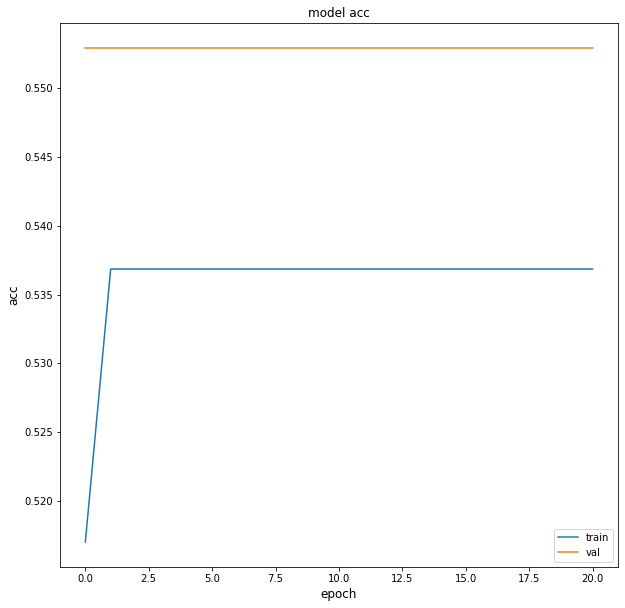

In [67]:
# show traning/validation plots
metric = "acc"
plt.figure(figsize=(10,10))
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [ ]:
y_train[-i].shape

In [ ]:
# get latest prediction
i = 80
x_pred = x_train[-i]
prediction = model.predict(x_pred.reshape(1,10,5))
y_pred = y_scaler.inverse_transform(prediction)
y_actual = y_train[-i]
print("Prediction: ",y_pred[0][0])
print( "Actual: ", y_actual[0])
print("MSE: ", (y_actual[0]- y_pred[0][0])**2)

# plot latest prediction
#plt.plot(np.arange(1,y_pred.shape[1]+1),y_pred[0]);
#plt.plot(np.arange(y_pred.shape[1]+1,len(y_actual[0])+1),y_actual[0]);